### Market features beyond alpha factors 

We calculate stock and market features which we hope will enhance the prediction potential of underlying alpha factors. 

Features serve as additional inputs that provide our  alpha model more context about market conditions.  Therefore, considered alpha models may be able to  learn to adjust their predictions accordingly. 

For example, adding volatility features including stocks and market volatility could result that certain alpha factors are particularly predictive in the presence of market volatility. Indeed, prior to the 2008 market crash, high market volatility were observed and this situation, alpha models such as mean-reversion tend to perform pretty well. 

Recall that alpha factors are signals that are ideally predictive of whether future stocks returns may be positive or negative and by how much.

Features are similar but they do not have as high requirement to be predictive on their own.

A good feature may be one that is useful in combination with other features or alpha factors. In other words, a good feature can be a conditioal factor.

In the following we are going to calculate features from our stock universe. In particular we will first focus on the so-called Univeral Quant Features that includede `stock volatility` and `stock dollar volume`. Then we will calculate Market Regime Features know as `Market dispersion` and `Market volatility`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib

In [2]:
plt.style.use('ggplot')
idx = pd.IndexSlice
plt.rcParams['figure.figsize'] = (16, 4)

In [3]:
# build a function to construct a  universe of assets and their historical trading data

def select_and_process_historical_data(filename, traded_year=8, number_stocks=10):
    '''
    filename: is the csv file name that contains the historical 
                trading data to be processed and used to construct the portfolio
                
    '''
    data = pd.read_csv(filename, index_col=[0,1], parse_dates=True)
    
    # filter the dataframe by selecting the adjencent prices and select 10 years of trading data
    data = data.filter(like='adj_').rename(columns=lambda x: x.replace('adj_', '')).loc[idx[:, '2006':'2016'], :].dropna()
    
    # select the assets: we select the 10 most traded assets over the 10 years with at least 8 years of data
    dv = data.close.mul(data.volume)
    dv = dv.unstack('ticker').dropna(thresh=traded_year*252, axis=1).rank(axis=1, ascending=True).mean().nlargest(number_stocks)
    selected_assets = dv.index.tolist()
    universe = data.loc[idx[selected_assets, :], :]
    
    # remove data outlier by removing returns that are at least 100 per cent
    universe = universe[universe.close.pct_change().between(-1, 1)]
    
    
    return universe

In [4]:
universe = select_and_process_historical_data('HISTORIC_PRICES.csv', 8, 10)
universe

open       high        low      close       volume
ticker date                                                               
AAPL   2006-01-04   9.655252   9.764489   9.574288   9.634690  154900900.0
       2006-01-05   9.616698   9.625694   9.477903   9.558867  112355600.0
       2006-01-06   9.669389   9.857019   9.580714   9.805613  176114400.0
       2006-01-09   9.860874   9.921276   9.733646   9.773485  168760200.0
       2006-01-10   9.799188  10.524006   9.745212  10.391637  569967300.0
...                      ...        ...        ...        ...          ...
CSCO   2016-12-23  29.484966  29.542893  29.349802  29.475311    9167598.0
       2016-12-27  29.581511  29.755293  29.542893  29.620129   14175488.0
       2016-12-28  29.639438  29.707020  29.301529  29.369111   12022231.0
       2016-12-29  29.320838  29.494620  29.282220  29.407729   10995584.0
       2016-12-30  29.504275  29.542893  29.089130  29.176020   20190029.0

[27688 rows x 5 columns]

In [5]:
selected_assets = universe.index.unique('ticker')
selected_assets

Index(['AAPL', 'GOOGL', 'MSFT', 'BAC', 'XOM', 'C', 'JPM', 'GE', 'INTC',
       'CSCO'],
      dtype='object', name='ticker')

## Features

In [6]:
close_prices_daily_ret = universe.close.pct_change().dropna()
close_prices_daily_ret

ticker  date      
AAPL    2006-01-05   -0.007870
        2006-01-06    0.025813
        2006-01-09   -0.003277
        2006-01-10    0.063248
        2006-01-11    0.037596
                        ...   
CSCO    2016-12-23    0.002298
        2016-12-27    0.004913
        2016-12-28   -0.008475
        2016-12-29    0.001315
        2016-12-30   -0.007879
Name: close, Length: 27687, dtype: float64

In [7]:
# This is the diction that will contain all the features that we will be calculated
quant_features_dict = {}

In [8]:
daily_ret = close_prices_daily_ret.unstack('ticker').dropna()
daily_ret                                          

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
date,,,,,,,,,,
2006-01-05,-0.007870,0.013476,0.000742,0.001288,-0.004951,0.004961,0.003029,-0.002548,0.013898,0.028011
2006-01-06,0.025813,0.031956,-0.002964,-0.001501,0.019732,0.000000,0.007046,0.006812,0.001523,0.022888
2006-01-09,-0.003277,0.002663,-0.001858,0.000644,-0.000505,-0.004731,0.016242,-0.002537,0.006081,0.015450
2006-01-10,0.063248,0.006125,0.005212,-0.008369,0.007744,0.003100,0.001475,-0.005370,-0.013226,-0.004722
2006-01-11,0.037596,0.003981,0.010741,-0.002380,0.006849,0.009065,-0.000737,0.006820,0.000770,0.022667
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,0.001978,-0.002322,-0.004878,0.002662,-0.001761,0.008266,0.001841,0.001886,0.001083,0.002298
2016-12-27,0.006351,0.002637,0.000633,0.000442,0.000441,0.001640,0.000919,0.000627,0.002705,0.004913
2016-12-28,-0.004264,-0.006618,-0.004583,-0.012384,-0.004959,-0.017188,-0.007231,-0.006270,-0.011869,-0.008475


#### Stock volatility
Variations of each stock aver a specified time horizon

In [9]:
#window_length = 5, 20

def annualized_stock_volatility(daily_ret, window_length, assets):
    """"
    Calculate the stock volatility over a specified period of time 

    Args:
        daily_ret (DataFrame): the DataFrame of the universe daily return
        window_length (int): length of the time time window to consider. 
                             can be one week (5 days), one month (20 days)), etc.

    Returns:
        DataFrame: columns are the tickers, rows are the date, 
                   and entries are the calculated volatily for each ticket and each date
    """

    
    vol_df_list = []
    for ticker in assets:
        vol = []
        list_dates = []
        
        daily_ret_by_ticker = daily_ret[ticker]
        for start in range(len(daily_ret[ticker]) - window_length +1):
            end = start + window_length
            list_dates.append(daily_ret_by_ticker[start:end].index[-1])
            vol.append(np.sqrt(252)*daily_ret_by_ticker[start:end].std())
    
        vol_df_by_ticker = pd.DataFrame(vol, index=list_dates, columns=[ticker])
        vol_df_by_ticker.index.name = 'date'
        vol_df_list.append(vol_df_by_ticker)
    
    stock_vol_df = pd.concat(vol_df_list, axis=1)
    
    return stock_vol_df


        

In [10]:
vol_5day = annualized_stock_volatility(daily_ret, 5, selected_assets)
vol_5day.head()

,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
date,,,,,,,,,,
2006-01-11,0.468513,0.192106,0.089493,0.060834,0.149408,0.082501,0.106175,0.091425,0.157074,0.204249
2006-01-12,0.422515,0.276694,0.106084,0.058919,0.176870,0.079729,0.202278,0.129763,0.120722,0.248759
2006-01-13,0.428608,0.154663,0.099703,0.063137,0.191019,0.084193,0.195342,0.116588,0.118889,0.260761
2006-01-17,0.458068,0.153980,0.119153,0.069292,0.185242,0.111690,0.127538,0.117969,0.083642,0.243207
2006-01-18,0.386845,0.358111,0.120515,0.070135,0.211254,0.108709,0.116666,0.116544,0.774241,0.247327


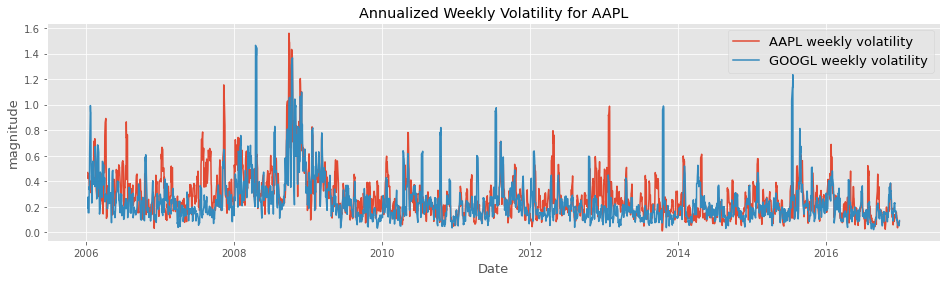

In [11]:
plt.plot(vol_5day['AAPL'], label='AAPL weekly volatility')
plt.plot(vol_5day['GOOGL'], label='GOOGL weekly volatility')

plt.legend(fontsize=13)
plt.xlabel('Date', fontsize=13)
plt.ylabel('magnitude', fontsize=13)
plt.title('Annualized Weekly Volatility for AAPL')
plt.show()

In [12]:
quant_features_dict['one_week_stock_vol'] = vol_5day.rank(axis=1, ascending=True, method='first').astype(int).stack()

### Stock Dollar Volume
It is the dollar amount of trades over a time horizon that can be one week, one month, etc. That means, we have to calculate the stock's average daily volume over the specified time period. 

In [13]:
volume_ = universe.volume.unstack('ticker').dropna().stack('ticker')
closing_price = universe.close.unstack('ticker').dropna().stack('ticker')

In [14]:
dollar_volume_df = volume_.mul(closing_price).unstack('ticker')
dollar_volume_df.head()

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
date,,,,,,,,,,
2006-01-04,1.492422e+09,6.820358e+09,1.185741e+09,6.545043e+08,8.156815e+08,7.624811e+08,3.989832e+08,5.601727e+08,8.298655e+08,1.186095e+09
2006-01-05,1.073992e+09,4.887328e+09,9.874689e+08,5.524870e+08,7.296514e+08,4.681789e+08,2.405451e+08,4.387145e+08,9.996643e+08,1.798077e+09
2006-01-06,1.726910e+09,8.285967e+09,2.060344e+09,4.642921e+08,7.531641e+08,5.611921e+08,2.379832e+08,5.172727e+08,8.338209e+08,1.899267e+09
2006-01-09,1.649375e+09,5.985038e+09,1.133026e+09,5.759326e+08,7.515053e+08,6.851071e+08,5.031678e+08,4.839989e+08,7.242560e+08,1.237889e+09
2006-01-10,5.922893e+09,4.282398e+09,1.329287e+09,5.716684e+08,7.804959e+08,5.584696e+08,5.051140e+08,4.889660e+08,8.518513e+08,1.157356e+09


In [15]:
def average_dollar_volume(dollar_volume_df, window_length, assets):
    
    adv_list = []
    for ticker in assets:
        adv = []
        list_dates = []
        
        for start in range(len(dollar_volume_df[ticker]) - window_length +1):
            end = start + window_length
            
            adv.append(np.sum(dollar_volume_df[ticker][start:end]) / window_length)
            list_dates.append(dollar_volume_df[ticker][start:end].index[-1])
            
        adv_by_ticker_df = pd.DataFrame(adv, index=list_dates, columns=[ticker])
        adv_by_ticker_df.index.name = 'date'
    
        adv_list.append(adv_by_ticker_df)
        
    adv_df = pd.concat(adv_list, axis=1)
        
    
    return adv_df

In [16]:
adv_5day = average_dollar_volume(dollar_volume_df, 5, selected_assets)
adv_5day.head()

,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
date,,,,,,,,,,
2006-01-10,2.373119e+09,6.052218e+09,1.339173e+09,5.637769e+08,7.660996e+08,6.070858e+08,3.771587e+08,4.978250e+08,8.478916e+08,1.455737e+09
2006-01-11,2.879963e+09,5.539553e+09,1.392256e+09,5.404263e+08,7.553374e+08,5.935787e+08,3.722908e+08,4.905808e+08,8.740577e+08,1.455572e+09
2006-01-12,3.358887e+09,5.502929e+09,1.384089e+09,5.063705e+08,7.933107e+08,6.015466e+08,3.971196e+08,5.052683e+08,8.687127e+08,1.285025e+09
2006-01-13,3.440453e+09,4.561204e+09,1.142822e+09,4.917250e+08,7.945964e+08,5.668483e+08,4.148448e+08,4.816252e+08,8.675831e+08,1.068869e+09
2006-01-17,3.565426e+09,4.138439e+09,1.155960e+09,4.812691e+08,8.076610e+08,5.308155e+08,3.731423e+08,4.589764e+08,1.034386e+09,9.853063e+08


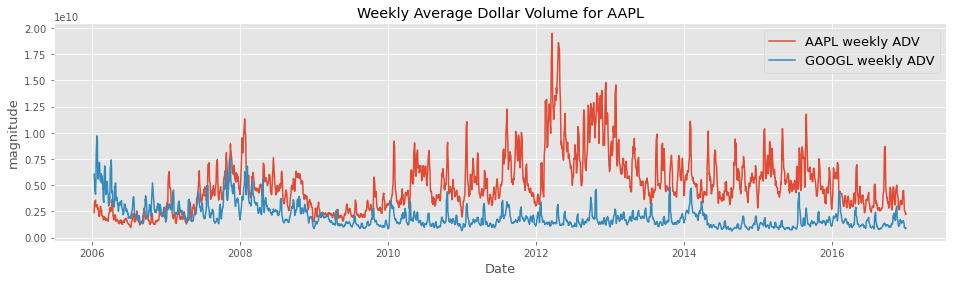

In [17]:
plt.plot(adv_5day['AAPL'], label='AAPL weekly ADV')
plt.plot(adv_5day['GOOGL'], label='GOOGL weekly ADV')

plt.legend(fontsize=13)
plt.xlabel('Date', fontsize=13)
plt.ylabel('magnitude', fontsize=13)
plt.title('Weekly Average Dollar Volume for AAPL')
plt.show()

In [18]:
quant_features_dict['one_week_adv'] = adv_5day.rank(axis=1, ascending=True, method='first').astype(int).stack()

### Market Regime Feastures
The terme market regime is another way to describe market conditions that broadly affect how stocks behave during a period of time.

Market regime changes over time. Therefore, it is helpful to generate features that capturew changes in these market conditions. 

In this section, we will estimate two market regimes: `Market dispersion` and `Market volatility`

#### Market dispersion
It looks at a cross-section of stocks and how spread they are. That means, we can look at the spread beetween the top performing and lowest performing stock on a single day. The difference between them can vary from day to day. 

Market dispersion can be calculated as the standard deviantion of a cross-sectional stocks on a single day; that means how dispersed the cross-sectional of stocks are from the center. 

Let $r_{i,t}$ denotes the daily return of stock $i$ at time time $t$. 

$\mu = \frac{1}{N}\sum_{i=1}^{N}r_{i,t}$

  $\text{Dispersion } = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(r_{i,t} - \mu)^2}$

In [19]:
def market_dispersion_regime(daily_ret_df, assets):
    
    
    
    dates = list(daily_ret.index.unique('date'))
    mean_returns = np.nanmean(daily_ret, axis=1)
    squared_deviations = (daily_ret - mean_returns[:, None])**2
    market_dispersion = np.sqrt(np.nanmean(squared_deviations, axis=1))
    market_dispersion = list(market_dispersion)
    
    market_dispersion_df = pd.DataFrame(index=dates, columns=assets)
    
    for date, dispersion in zip(dates, market_dispersion):
        market_dispersion_df.loc[date, : ] = dispersion
    
        
    return market_dispersion_df
    
                                 

In [20]:
market_dispersion_df = market_dispersion_regime(daily_ret, selected_assets)
market_dispersion_df.head()

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
2006-01-05,0.010188,0.010188,0.010188,0.010188,0.010188,0.010188,0.010188,0.010188,0.010188,0.010188
2006-01-06,0.01213,0.01213,0.01213,0.01213,0.01213,0.01213,0.01213,0.01213,0.01213,0.01213
2006-01-09,0.007148,0.007148,0.007148,0.007148,0.007148,0.007148,0.007148,0.007148,0.007148,0.007148
2006-01-10,0.020317,0.020317,0.020317,0.020317,0.020317,0.020317,0.020317,0.020317,0.020317,0.020317
2006-01-11,0.011538,0.011538,0.011538,0.011538,0.011538,0.011538,0.011538,0.011538,0.011538,0.011538


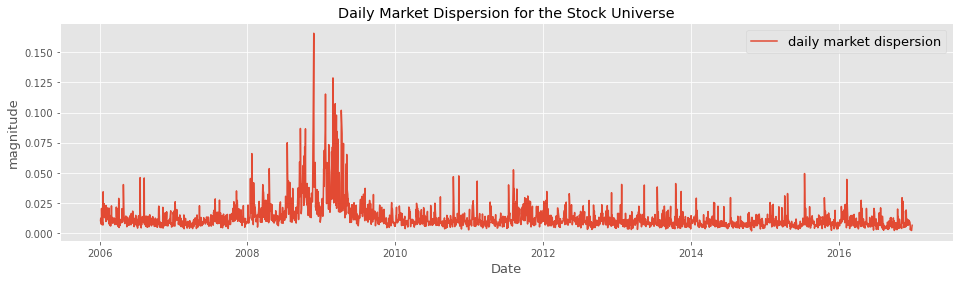

In [21]:
plt.plot(market_dispersion_df.loc[:, 'AAPL'], label='daily market dispersion')

plt.legend(fontsize=13)
plt.xlabel('Date', fontsize=13)
plt.ylabel('magnitude', fontsize=13)
plt.title('Daily Market Dispersion for the Stock Universe')
plt.show()

In [22]:
quant_features_dict['market_dispersion_5day'] = market_dispersion_df.rolling(window=5).mean().dropna(axis=0).rank(axis=0, ascending=True, method='first').astype(int).stack()

### Market volatility
It measures the standard deviation of the market  for a given time period. That means, the volatility of the stock universe over a time horizon.

In this case, we're approximating the "market" as the equal weighted average return of all the stocks in the stock universe.

##### Market return
$r_{m,t} = \frac{1}{N}\sum_{i=1}^{N}r_{i,t}$ for each day $t$ in `window_length`.  

##### Average market return
Also calculate the average market return over the `window_length` $T$ of days:  
$\mu_{m} = \frac{1}{T}\sum_{t=1}^{T} r_{m,t}$

#### Standard deviation of market return
Then calculate the standard deviation of the market return  
$\sigma_{m,t} = \sqrt{252 \times \frac{1}{N} \sum_{t=1}^{T}(r_{m,t} - \mu_{m})^2 } $ 

In [23]:
def market_volatility_regime(daily_ret, assets, window_length):
    
    std_mkt_ret = []
    dates = []
    
    
    for start in range(len(daily_ret) - window_length + 1):
        
        end = start + window_length
        dates.append(daily_ret[start:end].index[-1])
        market_return = np.nanmean(daily_ret[start:end], axis=1)
        average_market_return_mu = np.nanmean(market_return)
        
        std_market_return = np.sqrt(252*np.nanmean((market_return - average_market_return_mu)**2))
        
        std_mkt_ret.append(std_market_return)
    
    market_vol_df = pd.DataFrame(index=dates, columns=assets)    
    for date, mkt_vol in zip(dates, std_mkt_ret):
        market_vol_df.loc[date, :] = mkt_vol
    
        
    return market_vol_df

In [24]:
market_vol_5day = market_volatility_regime(daily_ret, selected_assets, 5)
market_vol_5day.head()

ticker,AAPL,GOOGL,MSFT,BAC,XOM,C,JPM,GE,INTC,CSCO
2006-01-11,0.048654,0.048654,0.048654,0.048654,0.048654,0.048654,0.048654,0.048654,0.048654,0.048654
2006-01-12,0.108075,0.108075,0.108075,0.108075,0.108075,0.108075,0.108075,0.108075,0.108075,0.108075
2006-01-13,0.09293,0.09293,0.09293,0.09293,0.09293,0.09293,0.09293,0.09293,0.09293,0.09293
2006-01-17,0.10691,0.10691,0.10691,0.10691,0.10691,0.10691,0.10691,0.10691,0.10691,0.10691
2006-01-18,0.165817,0.165817,0.165817,0.165817,0.165817,0.165817,0.165817,0.165817,0.165817,0.165817


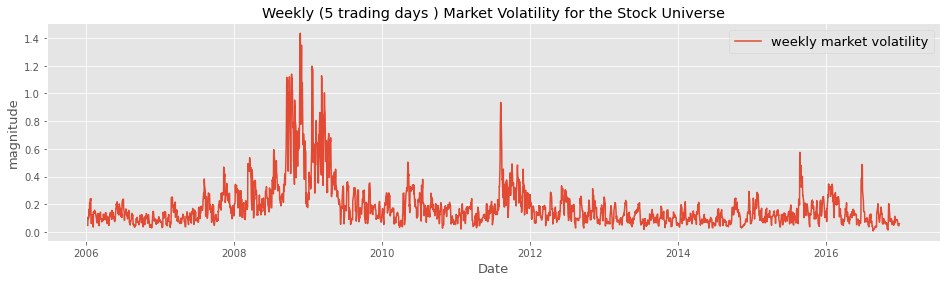

In [25]:
plt.plot(market_vol_5day.loc[:, 'AAPL'], label='weekly market volatility')

plt.legend(fontsize=13)
plt.xlabel('Date', fontsize=13)
plt.ylabel('magnitude', fontsize=13)
plt.title('Weekly (5 trading days ) Market Volatility for the Stock Universe')
plt.show()

In [26]:
quant_features_dict['market_vol_5day'] = market_vol_5day.rank(axis=0, ascending=True).astype(int).stack('ticker')